Dane pobrane ze strony https://www.kaggle.com/c/tabular-playground-series-mar-2021/data
Ponieważ jak się okazuje algorytm lgbm dość dobrze sobie radzi z cechami kategorialnymi oraz  z brakami danych, nie wykonam pierwszego kroku czyli EDA

In [16]:
import pandas as pd
import numpy as np
import os

data_path = "E:\page_ds\LightGBM_step_by_step"
pict_path = os.path.join(data_path, r"foto")

MainData = pd.read_csv(os.path.join(data_path, "train.csv"))

#podział na cechy oraz zmienną celu
y = MainData['target'].copy()
X = MainData.drop(columns=['id','target']).copy()

#lista cech kategorialnych
X_cat_col = list(X.loc[:,X.dtypes!=np.number].columns)


In [3]:
display(X)

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,A,I,A,B,B,BI,A,S,Q,A,...,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915
1,A,I,A,A,E,BI,K,W,AD,F,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
2,A,K,A,A,E,BI,A,E,BM,L,...,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452
3,A,K,A,C,E,BI,A,Y,AD,F,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
4,A,I,G,B,E,BI,C,G,Q,A,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,A,N,F,A,E,BU,A,AS,K,A,...,0.500730,0.662428,0.671927,0.390566,0.145840,0.262767,0.514248,0.519340,0.617436,0.688007
299996,A,K,A,A,G,BI,A,K,AE,E,...,0.790664,0.821657,0.620356,0.384891,0.735879,0.547731,0.726653,0.470575,0.275743,0.638939
299997,A,G,M,A,H,BI,C,L,F,A,...,0.522347,0.407037,0.232436,0.832482,0.810663,0.596939,0.308821,0.373997,0.518024,0.452144
299998,B,H,A,D,B,BI,A,AA,AX,A,...,0.812891,0.808045,0.630708,0.346898,0.735147,0.563488,0.609836,0.680430,0.318453,0.335822


LGBM obsługuje tylko zmienne categorialne więc wszystkie cechy typu _object_ należy najpierw przekonwertować do tego typu
https://lightgbm.readthedocs.io/en/v3.3.2/Advanced-Topics.html


In [18]:
X_category_col = list(X.loc[:,X.dtypes!=np.number].columns)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   cat0    300000 non-null  category
 1   cat1    300000 non-null  category
 2   cat2    300000 non-null  category
 3   cat3    300000 non-null  category
 4   cat4    300000 non-null  category
 5   cat5    300000 non-null  category
 6   cat6    300000 non-null  category
 7   cat7    300000 non-null  category
 8   cat8    300000 non-null  category
 9   cat9    300000 non-null  category
 10  cat10   300000 non-null  category
 11  cat11   300000 non-null  category
 12  cat12   300000 non-null  category
 13  cat13   300000 non-null  category
 14  cat14   300000 non-null  category
 15  cat15   300000 non-null  category
 16  cat16   300000 non-null  category
 17  cat17   300000 non-null  category
 18  cat18   300000 non-null  category
 19  cont0   300000 non-null  float64 
 20  cont1   300000 non-null  f

##### Buduję model korzystając z metod podziału zbioru na część trenującą oraz walidacyjną a następnie z wbudowanej w pakiet optuna metody _integration_ gdzie wywołując callback ucina nierokujące triale co teoretycznie powinno skrócić czas treenowania modelu 

In [ ]:
# część poświęcona budowie modelu oraz optymalnemu doborowi hiperparametrów
import optuna
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score # dane są nisko niezbalansowane przez co powinniśmy rozpatrzyć losowanie warstwowe
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc


def objective(trial):
    
    # dzielimy zbiór na część treningową i testową przez co zbiór będzie uczony jedynie na 80% całości
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state=128262)

    # wrzucam dane do specjalnego typu danych dedykowanego algorytmowi LGBM
    dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = X_category_col)
    dtest = lgb.Dataset(X_test, label=y_test, categorical_feature = X_category_col)
    
    #definiuję słownik parametrów zgodnie z wytycznymi opisanymi w poście
    param_grid = {
        "objective": "binary",
        "metric": "auc",
        #"verbosity": -1,
        "boosting_type": "gbdt",
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=200),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }
    
    #dodaję wywołanie zwrotne do cięcia nierokujących triali
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, metric = "auc")
    gbm = lgb.train(param_grid, dtrain, valid_sets=dtest, callbacks=[pruning_callback])
    
    y_hat = gbm.predict(X_test)
    pred_labels = np.rint(y_hat)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

if __name__ == "__main__":
    study = optuna.create_study(
        #direction="minimize", study_name="LGBM Classifier"
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
    )
    
    #study.optimize(lambda trial: objective(trial, X, y), n_trials=100)
    study.optimize(objective, n_trials=100)
    
    #print("Number of finished trials: {}".format(len(study.trials)))
    
    #print(study.best_trial)

In [23]:
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

	n_estimators: 1000
	learning_rate: 0.2335666061969727
	num_leaves: 1840
	max_depth: 8
	min_data_in_leaf: 4000
	lambda_l1: 20
	lambda_l2: 0
	min_gain_to_split: 1.7795731225826308
	bagging_fraction: 0.9
	bagging_freq: 1
	feature_fraction: 0.6000000000000001


In [24]:
print("Number of finished trials: {}".format(len(study.trials)))

Number of finished trials: 100


Na koniec budujemy model na optymalnych parametrach, sprawdzam jego jakość oraz podstawowe metryki 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=1.7795731225826308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7795731225826308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Accuracy for validation set: 0.8480
Accuracy for train set: 0.8560
Wartość parametru Gini na zbiorze walidacyjnym to: 0.7842
Wartość parametru Gini na zbiorze treningowym to: 0.8043

ROC Curve

Confusion Matrix


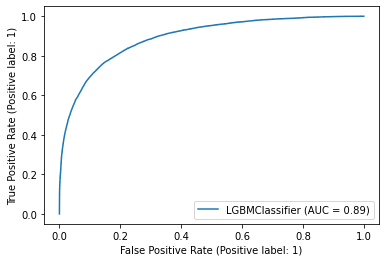

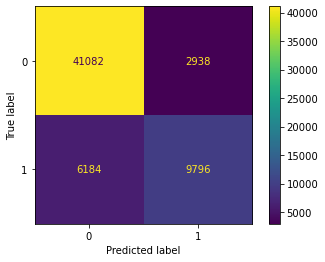

In [29]:
import matplotlib.pyplot as plt
import lightgbm as lgb
# dane są nisko niezbalansowane przez co powinniśmy rozpatrzyć losowanie warstwowe
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=128262)

# inicjalizujemy model na wymyślonych przeze mnie parametrach (PO BOŻEMU: tu powinny być parametry z Optuny!!!)
lgb_clf = lgb.LGBMClassifier(learning_rate=0.2335666061969727,
                             num_leaves=1840,
                             max_depth=8,
                             n_estimators=1000,
                             objective='binary',
                             min_data_in_leaf = 4000,
                             reg_alpha = 20,
                             #reg_lambda = 0, # to jest defaultowo
                             min_gain_to_split = 1.7795731225826308,
                             boosting_type ='gbdt',
                             bagging_fraction = 0.9,
                           #  bagging_freq = 1,
                             feature_fraction = 0.6,
                             #n_jobs=-1,
                             random_state=128262)


# uczymy model, korzystamy z API sklearn
lgb_clf.fit(X_train, y_train)

# przeliczamy skoringi na zbiorze testowym aby sprawdzić jakość modelu w rozumieniu interesujących mnie miar
y_hat = lgb_clf.predict(X_test)

auc_val = roc_auc_score(y_test, lgb_clf.predict_proba(X_test)[:, 1])
auc_train = roc_auc_score(y_train, lgb_clf.predict_proba(X_train)[:, 1])

print("Accuracy for validation set: {0:.4f}".format(accuracy_score(y_test, y_hat)))
print("Accuracy for train set: {0:.4f}".format(accuracy_score(y_train, lgb_clf.predict(X_train))))

print("Wartość parametru Gini na zbiorze walidacyjnym to: {0:.4f}".format(2*auc_val-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze treningowym to: {0:.4f}".format(2*auc_train-1)) # Gini = 2*AUC-1

print("\nROC Curve")
print(RocCurveDisplay.from_estimator(lgb_clf, X_test, y_test))
#RocCurveDisplay.from_estimator(lgb_clf, X_test, y_test)
#plt.savefig(os.path.join(pict_path, "2_ROC_cur_clf.png"), format="png" , dpi=300, facecolor="White")

print("\nConfusion Matrix")
#print(plot_confusion_matrix(xgb_clf, X_test, y_test))
cm = confusion_matrix(y_test, y_hat, labels=lgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lgb_clf.classes_)
print(disp.plot())
#wyk = disp.plot()
#plt.savefig(os.path.join(pict_path,"1_conf_matrix_clf.png"), format="png" , dpi=300, facecolor="White")
plt.show()

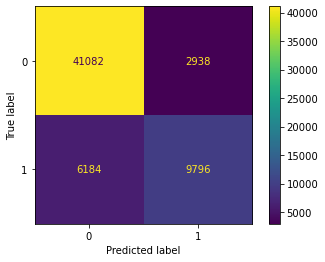

In [32]:
wyk = disp.plot()
plt.savefig(r"E:\page_ds\LightGBM_step_by_step\foto\1_conf_matrix_clf.png", format="png" , dpi=300, facecolor="White")
